## Regression with BIWI head pose dataset

This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

## Getting and converting the data

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE) # BIWI Head pose dataset을 fastai library를 통해 받아옴.

In [4]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [5]:
fname = '09/frame_00667_rgb.jpg'

In [6]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

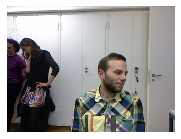

In [7]:
img = open_image(path/fname)
img.show()

In [8]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [9]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [10]:
get_ctr(fname)

tensor([263.9104, 428.5814])

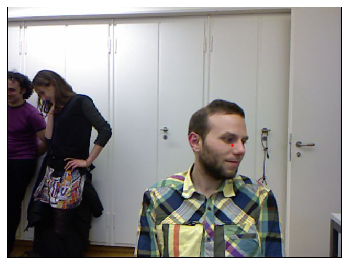

In [11]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6)) # 빨간점은 머리의 중앙에 위치하는 점. 저 점의 위치를 찾는것이 목표이다. (ground truth, target)

## Creating a dataset

In [12]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

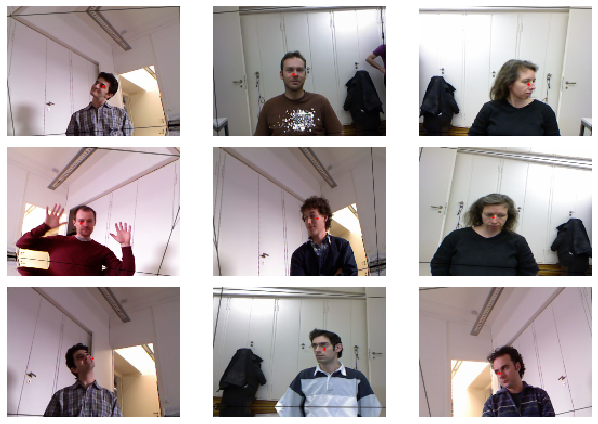

In [13]:
data.show_batch(3, figsize=(9,6))

## Train model

In [14]:
learn = cnn_learner(data, models.resnet34) # 무적의 ResNet34. 이제는 그냥 믿고 쓰는듯 하다.

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


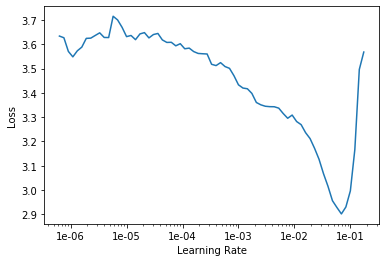

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
lr = 2e-2

In [18]:
learn.fit_one_cycle(5, slice(lr)) # 1 epoch만에 val loss가 엄청나게 내려갔고, 5 epoch만에 0.001이 나왔다.

epoch,train_loss,valid_loss,time
0,0.116408,0.004143,00:11
1,0.039559,0.003456,00:11
2,0.014244,0.001619,00:11
3,0.008362,0.002192,00:11
4,0.006808,0.001624,00:11


In [19]:
learn.save('stage-1')

In [20]:
learn.load('stage-1');

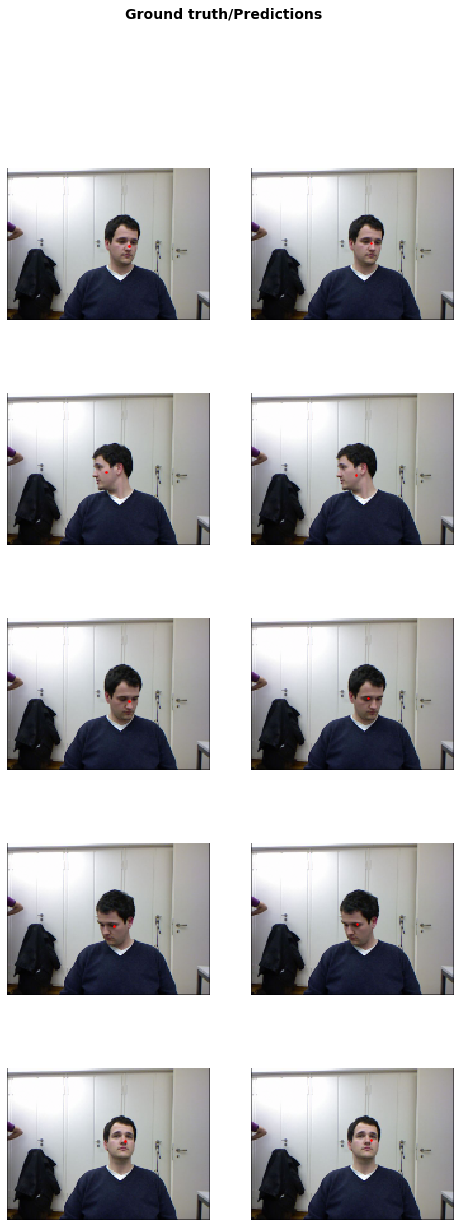

In [21]:
learn.show_results() # 거의 다 완벽하게 맞췄다. (loss가 0.001에서 이미 완벽하게 가능하다는 것을 알 수 있다.)

## Data augmentation

In [22]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)
# data augmentation 기법을 통해 변형된 정보를 제공해주자. 데이터셋이 적은 경우에는 rotation, torture, filter, lightning 등을 적용하여 조금 변형된 이미지를 추가 학습 데이터로 만들기도 한다.

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

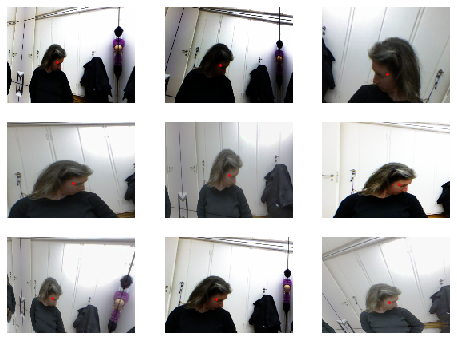

In [23]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6)) # 문제는 그럼에도 ResNet34가 무지하게 잘맞춘다.

## Short Comment:

- ResNet은 어마어마하다. 그냥 가벼운 ResNet34 써도 쉬운 pose estimation은 매우 잘풀어낸다.
- 왜곡을 주었는데도 잘 풀어내는게 신기했다. 물론 pose estimation 중에서도 쉬운 문제였고, face recognition도 아니었기 때문에 성능이 높은것도 있었다.
- 만약에 grayscale로 하거나, 해상도를 더 떨어뜨려도 찾을 수 있을지 궁금하다.